In [1]:
import os
import torch
import sklearn
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

In [2]:
def load_imdb_data(data_file,column):
    df = pd.read_csv(data_file)
    df.fillna(0, inplace=True)
    df.replace(-1, 2, inplace=True)
    count_0 = labels.count(0)
    count_1 = labels.count(1)
    count_2 = labels.count(2)
    texts = df['reviewText'].tolist()
    labels = df[column].tolist()
    labels = [int(element) for element in labels]
    return texts, labels

In [2]:
import pandas as pd
import random

def load_imdb_data(data_file, column):
    # Read the dataframe
    df = pd.read_csv(data_file)
    
    # Fill NaN values with 0 and replace -1 with 2
    df.fillna(0, inplace=True)
    df.replace(-1, 2, inplace=True)

    # Extract text and labels
    texts = df['reviewText'].tolist()
    labels = df[column].tolist()
    labels = [int(element) for element in labels]

    # Count the occurrences of each label
    count_0 = labels.count(0)
    count_1 = labels.count(1)
    count_2 = labels.count(2)

    # Find the minimum count between count_1 and count_2
    min_count = count_1 + count_2

    # Randomly sample min_count instances with label 0
    indices_label_0 = [i for i, label in enumerate(labels) if label == 0]
    sampled_indices_label_0 = random.sample(indices_label_0, min_count)

    # Find indices of instances with label 1 and 2
    indices_label_1 = [i for i, label in enumerate(labels) if label == 1]
    indices_label_2 = [i for i, label in enumerate(labels) if label == 2]

    # Include all instances with labels 1 and 2
    sampled_indices_label_1 = indices_label_1
    sampled_indices_label_2 = indices_label_2

    # Create a new balanced list of labels and text
    balanced_labels = [label for i, label in enumerate(labels) if i in sampled_indices_label_0 + sampled_indices_label_1 + sampled_indices_label_2]
    balanced_texts = [text for i, text in enumerate(texts) if i in sampled_indices_label_0 + sampled_indices_label_1 + sampled_indices_label_2]

    return balanced_texts, balanced_labels



In [3]:
data_file = "D:\ISE540\Team project\Amazonfoodnew - Amazonfoodnew.csv"
texts, labels = load_imdb_data(data_file,'packing/outter appearance/shipping')

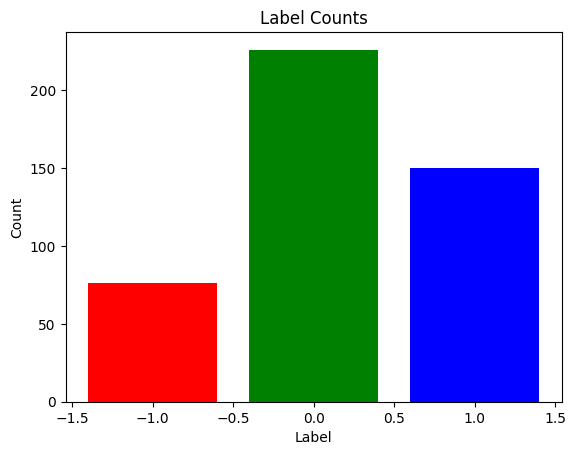

In [5]:
import matplotlib.pyplot as plt
# Count occurrences of each label
label_counts = {0: labels.count(0), 1: labels.count(1), -1: labels.count(2)}

# Plotting the bar chart
plt.bar(label_counts.keys(), label_counts.values(), color=['green', 'blue', 'red'])
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [6]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [8]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [9]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            # labels = batch['label'].to(device).long()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [32]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    # return preds
    if preds.item() == 1:
        return "positive"
    elif preds.item() == 0: 
        return "not relevant"
    else:
        return "negative"
    return "positive" if preds.item() == 1 else "negative"

In [11]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 3
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [13]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [15]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

d:\Anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.5934
              precision    recall  f1-score   support

           0       0.58      0.91      0.71        43
           1       0.56      0.31      0.40        32
           2       0.83      0.31      0.45        16

    accuracy                           0.59        91
   macro avg       0.66      0.51      0.52        91
weighted avg       0.62      0.59      0.56        91

Epoch 2/4
Validation Accuracy: 0.5604
              precision    recall  f1-score   support

           0       0.58      0.98      0.72        43
           1       0.42      0.16      0.23        32
           2       0.67      0.25      0.36        16

    accuracy                           0.56        91
   macro avg       0.55      0.46      0.44        91
weighted avg       0.54      0.56      0.49        91

Epoch 3/4
Validation Accuracy: 0.6044
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        43
           1   

In [33]:
test_text = "nice shipping."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
# print("The packing is really good.")
print(f"Predicted sentiment: {sentiment}")

The packing is really good.
Predicted sentiment: not relevant
